# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.optimize as opt
import glob
import math
import os
import sys

plt.rcParams["font.size"] = 15
plt.rcParams["font.family"] = "Verdana"


# Variables

In [23]:
start_time = pd.to_datetime("2025-05-13 12:53:00", format = '%Y-%m-%d %H:%M:%S')  # Adjust the date and time as needed
starttime = 7
FN ='HS006_400_20min_60x1_1500stat_LP5_' #Input the file name without the extension

# Data import

In [ ]:
files = glob.glob(FN +"*.txt")

#############################################
# Initialize an empty list for reading data and an empty dictionary for selected data
rmn = []
selected_data = {}

# Sort the files list
files.sort(key=str.lower)

# Define the number of rows per spectrum
rows_per_spectrum = 391

# Loop through the files and read them
for n in files:
    try:
        # Read the entire file into a DataFrame
        data = pd.read_csv(n, sep='\t', header=None, names=['Depth', 'Wavenumber', 'Intensity'], skiprows=0, index_col=False)
        
        # Determine the number of spectra in the file
        num_spectra = len(data) // rows_per_spectrum
        
        # Split the data into individual spectra
        spectra = [data.iloc[i*rows_per_spectrum:(i+1)*rows_per_spectrum].drop(columns=['Depth']) for i in range(num_spectra)]
        
        # Append all spectra to the rmn list
        rmn.extend(spectra)
        
        # Store each spectrum in the selected_data dictionary with a unique key
        for i, spectrum in enumerate(spectra):
            selected_data[f"{n}_spectrum_{i+1}"] = spectrum
    except pd.errors.ParserError:
        # Handle the exception if there is a parsing error
        print(f"Error parsing file: {n}")

measdur = 62 # Duration of the measurement in seconds

# Plotting and making GIF

C:\Users\6104029\AppData\Local\Temp\ipykernel_16836\1914700248.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, 5))


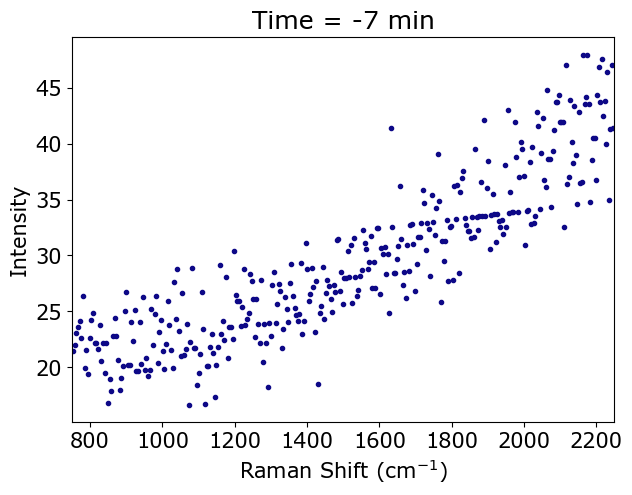

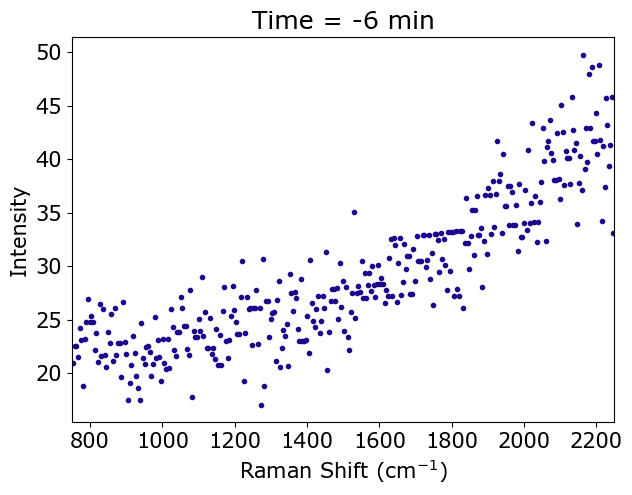

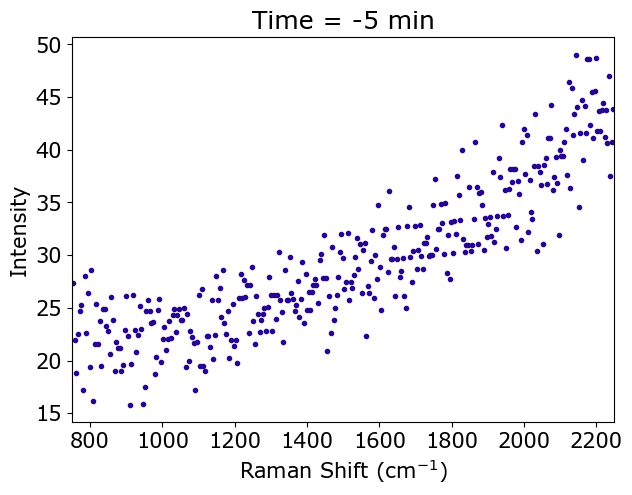

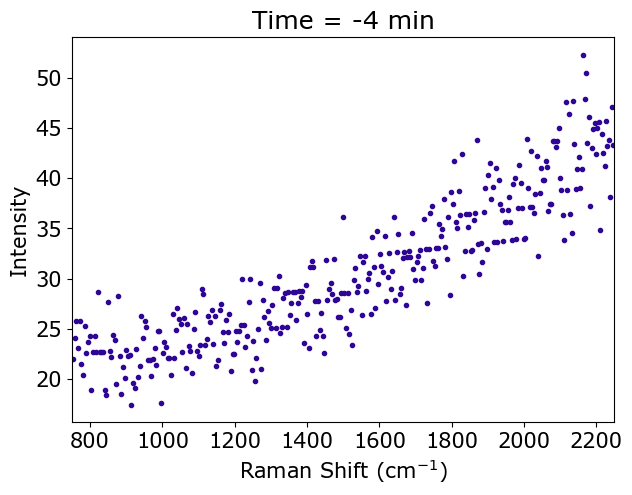

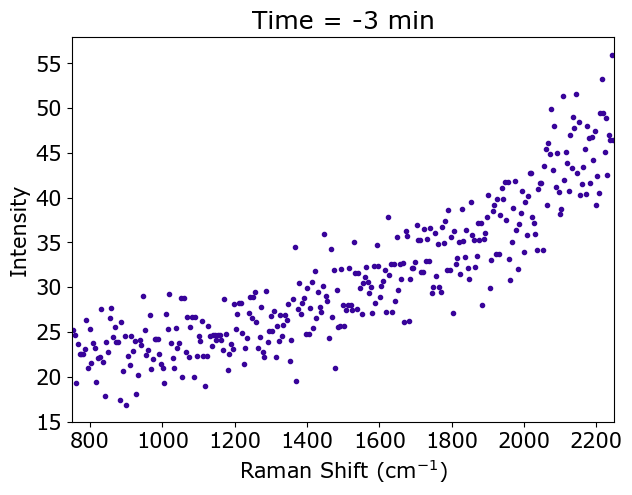

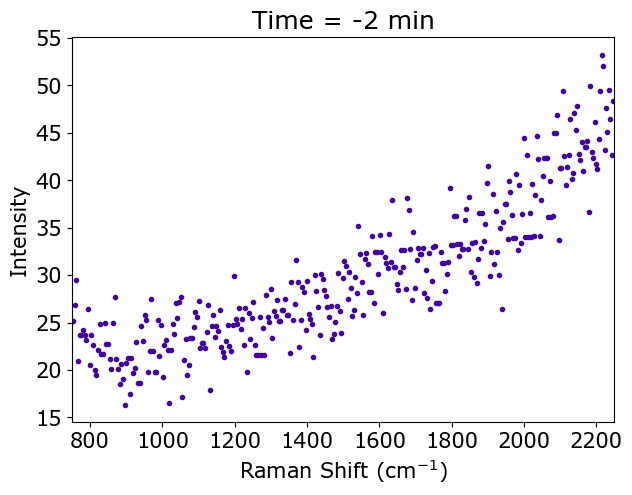

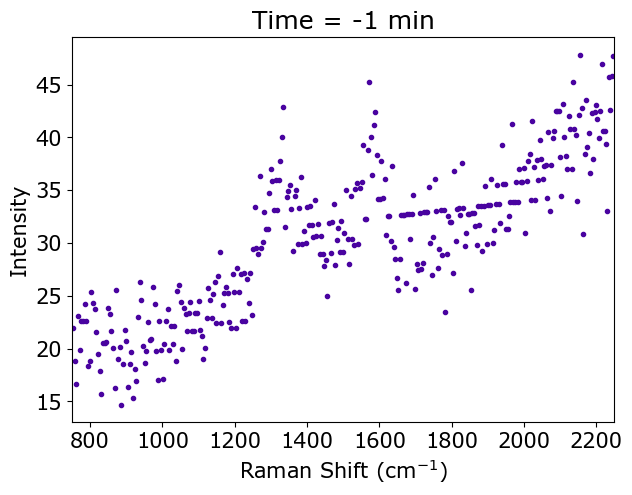

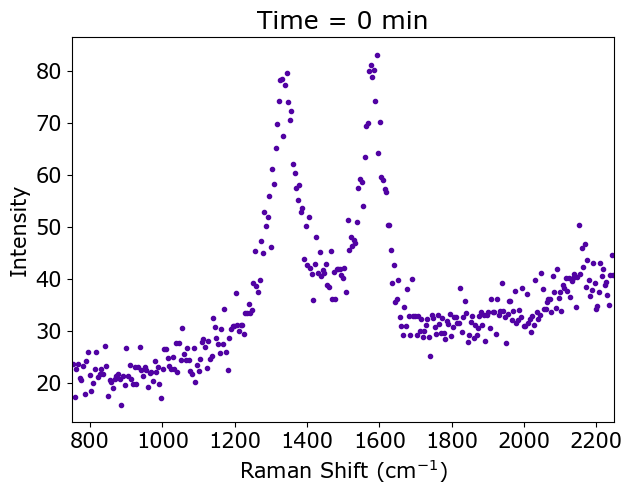

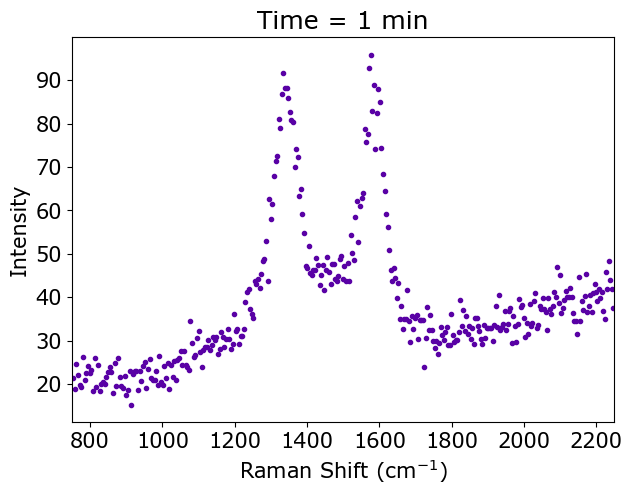

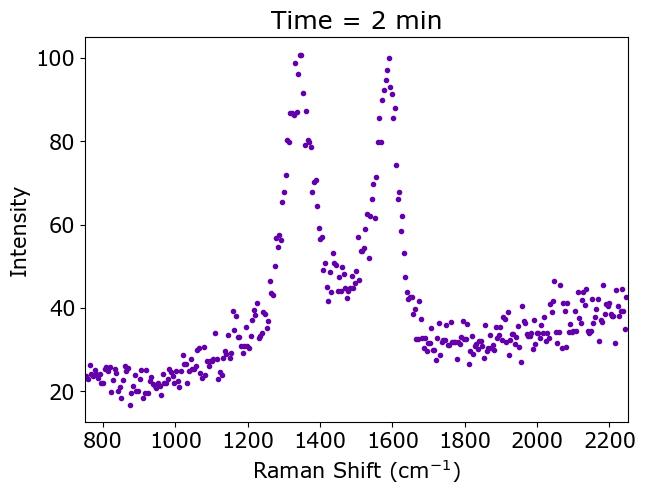

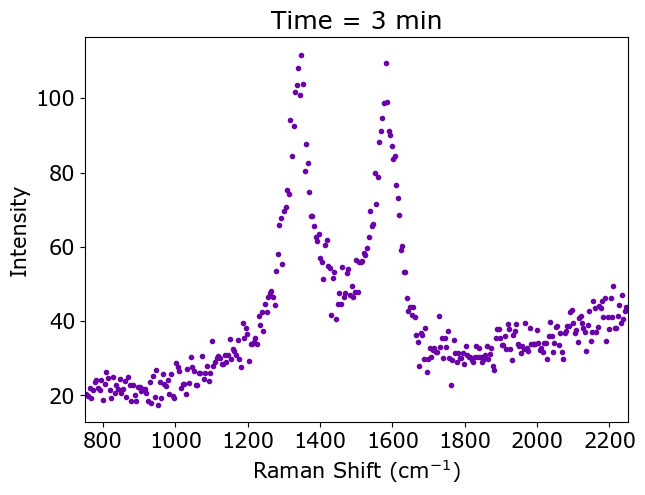

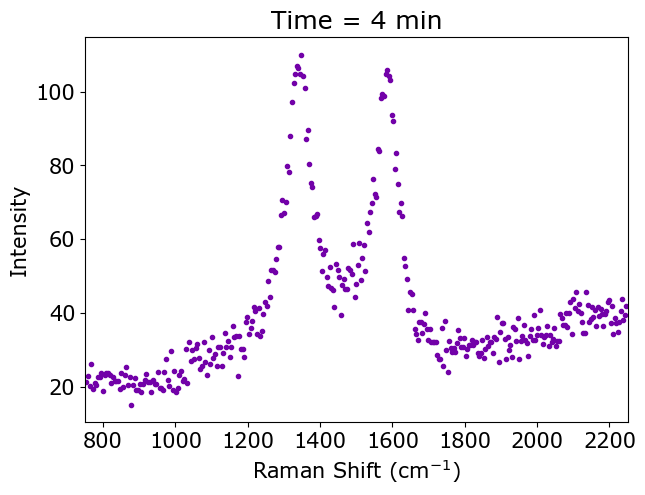

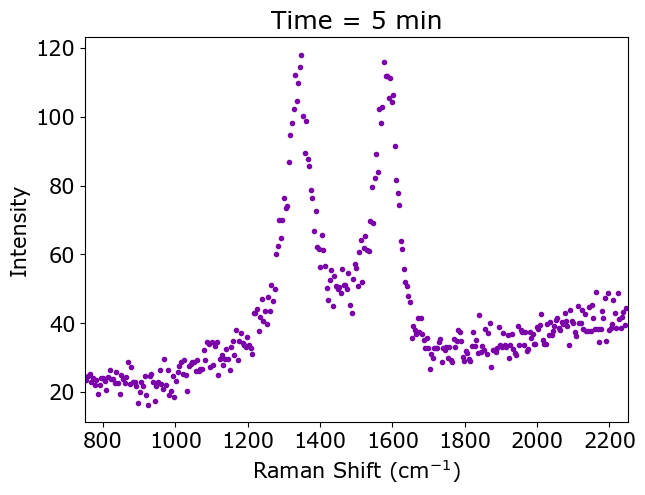

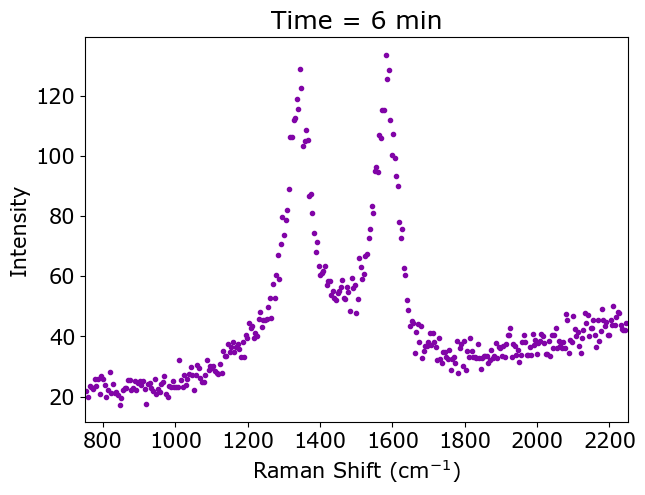

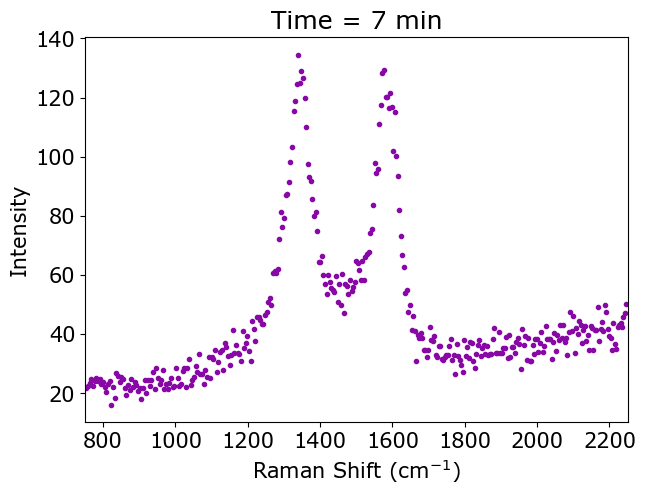

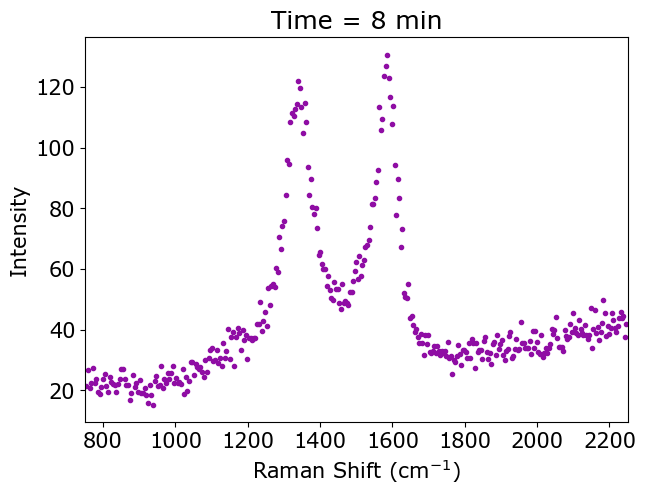

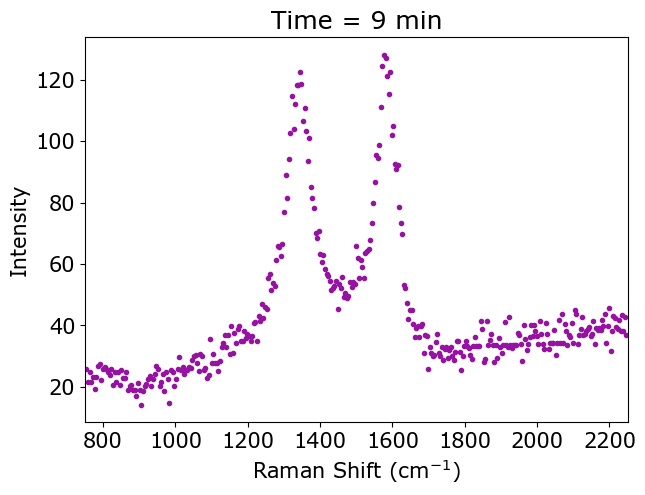

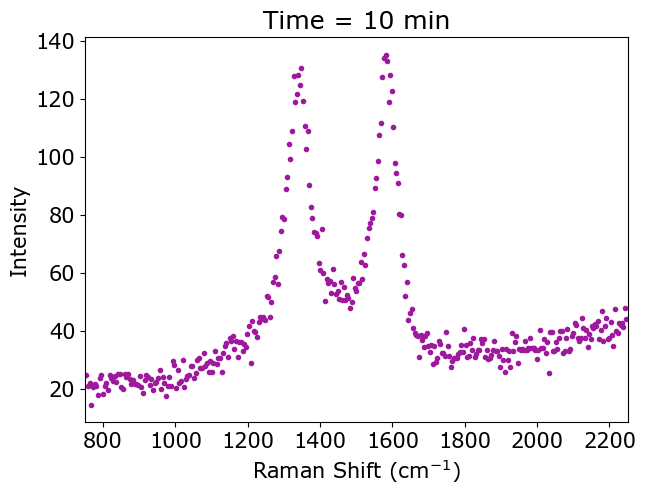

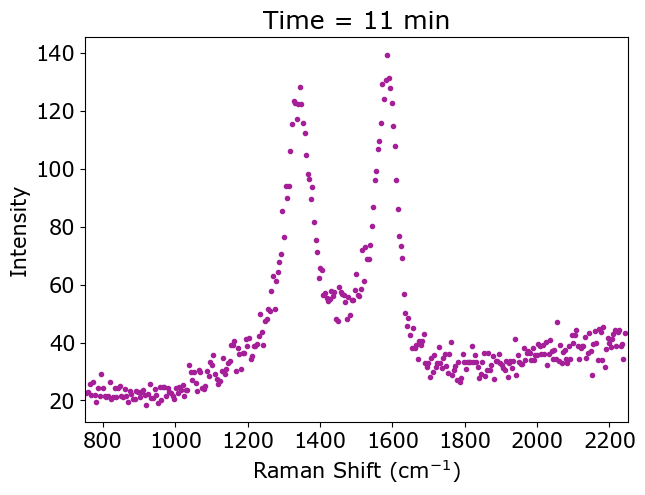

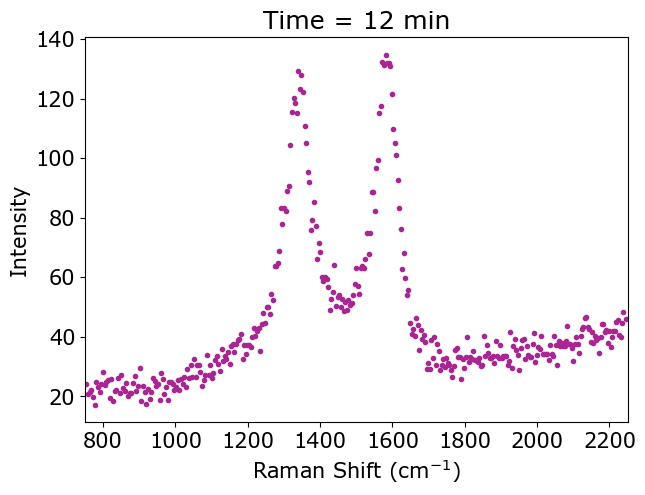

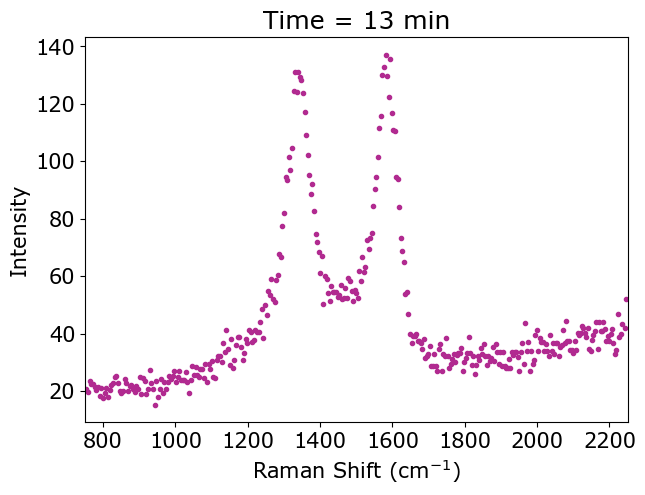

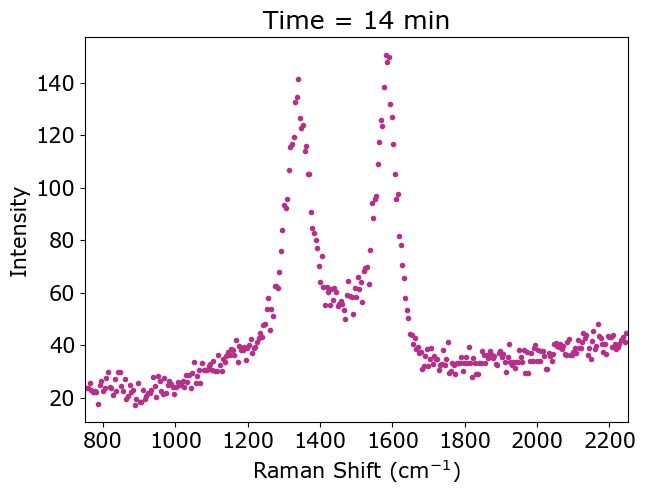

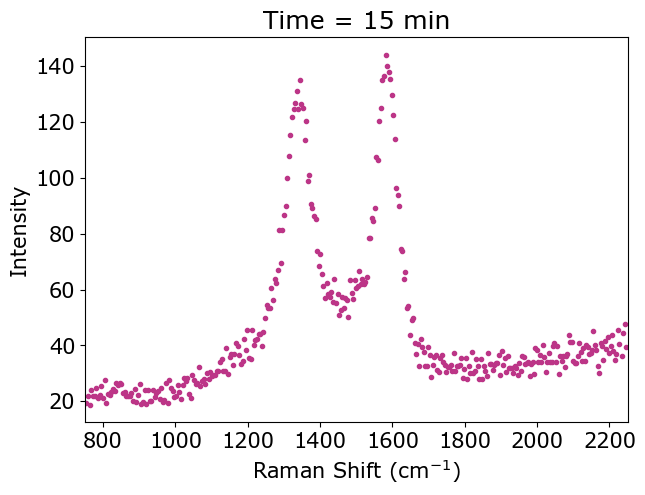

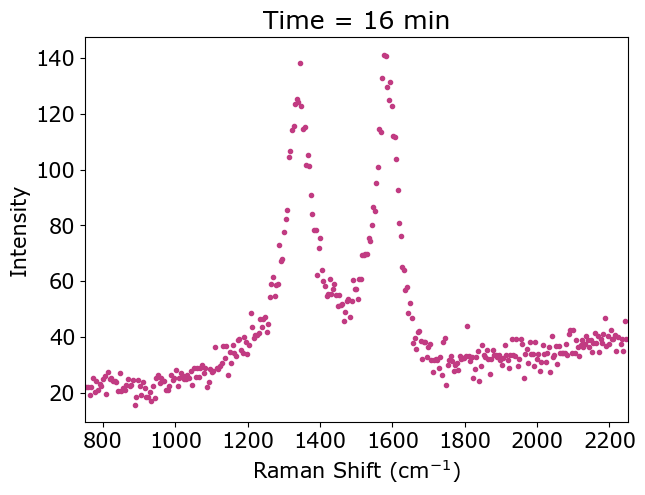

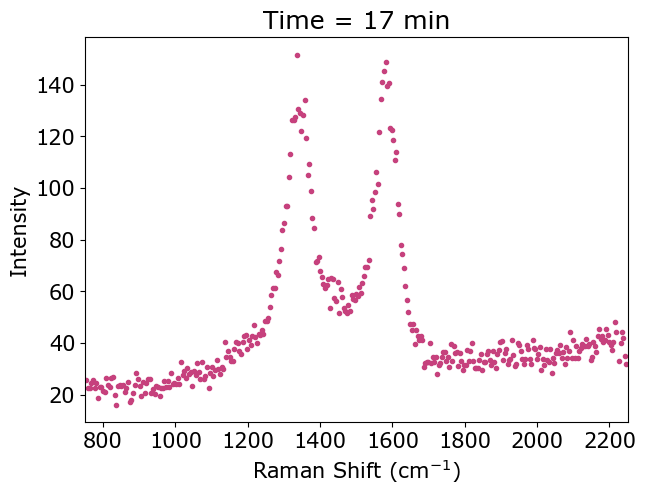

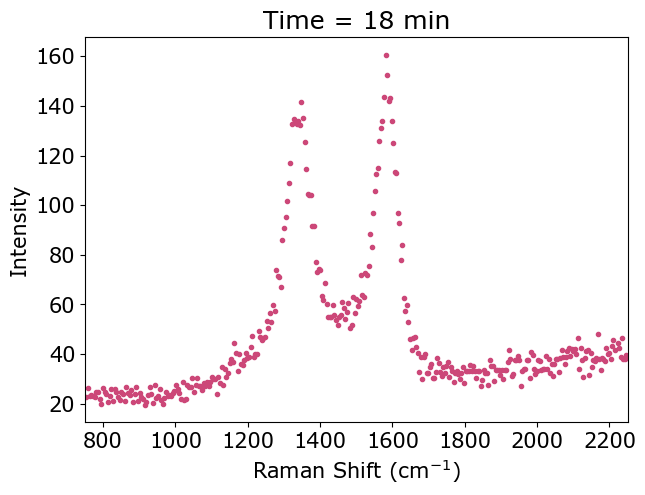

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# ADJUSTABLES:
#File location to save images in
# # Create a folder to store the data if it doesn't exist
folder_path = './IMG'
os.makedirs(folder_path, exist_ok=True) 
b1 = 750 # Lower bound of the Raman shift
b2 = 2250

loc = folder_path


####################################################
# Assuming 'rmn' is the list of spectra DataFrames
clr = plt.cm.plasma(np.linspace(0, 0.5, len(rmn)))  # Adjusted to use len(rmn)
# fig, ax = plt.subplots(figsize=(7, 5))

for i, spectrum in enumerate(rmn):
    fig, ax = plt.subplots(figsize=(7, 5))
    x = spectrum['Wavenumber'].astype(float)  # Convert 'x' values to numeric type
    y = spectrum['Intensity']
    xc = x[(x > b1) & (x < b2)]
    yc = y[(x > b1) & (x < b2)]
    plt.plot(xc, yc,'.', color=clr[i])
    plt.xlabel('Raman Shift (cm$^{-1}$)')
    plt.ylabel('Intensity')
    plt.title(f"Time = {int(i*measdur/60-starttime*measdur/60)} min")

    # plt.ylim(0, 600)
    # plt.yticks([])
    plt.xlim(b1, b2)
    
    #Pick your folder and filename here:
    plt.savefig(f"{loc}\\{FN}_spectrum_{i+1}.png", bbox_inches='tight')
####################################################

In [26]:
# Make a GIF from the images
# Importeer packages
from PIL import Image
import imageio
import os

# Pad naar map met PNG-bestanden (zorg dat loc correct is gedefinieerd)
# loc = 'pad/naar/jouw/map'  # <-- pas dit aan

# Maak een lijst van de png bestandsnamen
png = [doc for doc in os.listdir(loc) if doc.endswith('png')]

# Sorteer de PNG-bestandsnamenlocijst op nummer
def extract_number(png):
    return int(png.split('_')[-1].split('.')[0])
sorted_png = sorted(png, key=extract_number)

# Bepaaloc het doelocformaat op basis van de eerste afbeelocding
first_image = Image.open(os.path.join(loc, sorted_png[0]))
target_size = first_image.size  # (width, height)

# Open en resize de afbeelocdingen naar het doelocgrootte
Ilist = []
for fname in sorted_png:
    img = Image.open(os.path.join(loc, fname))
    if img.size != target_size:
        img = img.resize(target_size)
    Ilist.append(img)

# Converteer de locijst met afbeelocdingen naar een GIF
imageio.mimsave(os.path.join(loc, 'GIF.gif'), Ilist, duration=2)  # Duration in sec


# Fit the in-situ data

In [27]:
# Defines Lorentzian function
def L1(x,p,w,a):
    L = a*((1/math.pi)*0.5*w/((x-p)**2+(0.5*w)**2))
    return L

def L2(x,p1,w1,a1,p2,w2,a2,BGa, BGb, BGc):
    L = L1(x,p1,w1,a1) + L1(x,p2,w2,a2) + BGa*x**2 + BGb*x + BGc
    return L

# Define initial parameters for Lorentzian fit

#Sets empty lists for the lower boundary, initial guess, and upper boundary
B1=[]
IG=[]
B2=[]

#Peak position, width, and amplitude per band
#D band/ D1
B1D1 = np.array([1330, 0 , 0])
IGD1 = np.array([1345, 150, 0.5])
B2D1 = np.array([1360, 500,200])

#G band
B1G = np.array([1560, 0 , 0])
IGG = np.array([1570, 50, 0.5])
B2G = np.array([1600, 100,200])

#background
B1BGa = [-10]
IGBGa = [0]
B2BGa = [10]

B1BGb = [-10]
IGBGb = [0]
B2BGb = [10]

B1BGc = [-10]
IGBGc = [0]   
B2BGc = [10]

In [28]:
clr = plt.cm.plasma(np.linspace(0,0.5,len(rmn)))

#Choose the number of Lorentzians to fit
FUNC = L2

#Empty lists for the ratios and final fit
ratios = []
finalfit = []
ppos = []
RTR = []
Gbands = []
OPTDF = []



for i, spectrum in enumerate(rmn):
    # fig, ax = plt.subplots(figsize=(7, 5))
    x = spectrum['Wavenumber'].astype(float)  # Convert 'x' values to numeric type
    y = spectrum['Intensity']

    #Decide the boundaries for fitting
    b1 = 1000
    b2 = 2000
    xc = x[(x > b1) & (x < b2)]
    yc = y[(x > b1) & (x < b2)]
    # Normalize the data
    max_yc = yc[(x > 1000) & (x < 1500)].max()
    if max_yc == 0:
        print(f"Skipping spectrum {i+1} due to zero maximum intensity in the normalization range.")
        continue
    ycn = yc / max_yc

    #Initial guess, creates an empty list and adds the initial guess for each peak
    B1 = []; B1.extend(B1D1); B1.extend(B1G); B1.extend(B1BGa); B1.extend(B1BGb); B1.extend(B1BGc)#  B1.extend(B1D2);  
    IG = []; IG.extend(IGD1); IG.extend(IGG); IG.extend(IGBGa); IG.extend(IGBGb); IG.extend(IGBGc)#  IG.extend(IGD2);  
    B2 = []; B2.extend(B2D1); B2.extend(B2G); B2.extend(B2BGa); B2.extend(B2BGb); B2.extend(B2BGc)#  B2.extend(B2D2);  

    #Fit the data
    OPT = opt.curve_fit(FUNC,xc,ycn,p0=IG, bounds=(B1,B2))[0] 
    OPTDF.append(OPT)


In [29]:
rmn

[     Wavenumber  Intensity
 0       640.577    17.4919
 1       645.293    19.6122
 2       650.007    22.8039
 3       654.719    15.9177
 4       659.429    14.3331
 ..          ...        ...
 386    2297.500    46.7452
 387    2301.410    41.0015
 388    2305.310    41.6619
 389    2309.210    42.3228
 390    2313.100    49.4000
 
 [391 rows x 2 columns],
      Wavenumber  Intensity
 391    2317.000    43.6466
 392     640.577    15.9018
 393     645.293    20.1422
 394     650.007    18.5614
 395     654.719    22.2848
 ..          ...        ...
 777    2293.600    43.5229
 778    2297.500    41.6224
 779    2301.410    46.7673
 780    2305.310    38.4571
 781    2309.210    47.4529
 
 [391 rows x 2 columns],
       Wavenumber  Intensity
 782     2313.100    44.2675
 783     2317.000    48.7815
 784      640.577    17.4919
 785      645.293    21.2024
 786      650.007    17.5007
 ...          ...        ...
 1168    2289.690    49.2600
 1169    2293.600    42.8828
 1170    2297

In [30]:
for i, OPT in enumerate(OPTDF):
    fit = FUNC(xc, *OPT) #Bereken de gefitte y-waarden
    #Defines calculated G band
    Gband = L1(xc,OPT[3],OPT[4],OPT[5])
    #Calculates 20 center intensities
    Center20G = Gband[(xc > OPT[3]-10) & (xc < OPT[3]+10)]
    #Sums up all values in Center20
    SumCenter20 = sum(Center20G)
    #Sums up all values of total 
    Center20Fit = fit[(xc > OPT[3]-10) & (xc < OPT[3]+10)]
    SumCenter20Fit = sum(Center20Fit)

    RTRspectrum = SumCenter20/SumCenter20Fit * 100
    RTR.append(RTRspectrum)
    Gbands.append(Gband)
    
    #Calculate the ratios
    ratioDG = OPT[2]/OPT[5]

    widthG = OPT[4]
    #Add the ratios to the list ratios
    ratios.append([ratioDG, widthG])
    
    #Adds peak positions to the list ppos
    posD = OPT[0]
    posG = OPT[3]
    # posD2 = OPT[6]
    ppos.append([posD, posG])
    #Check the fit by calling finalfit afterwards
    for i, value in enumerate(OPT):
        finalfit.append("{:<10} {:<10} {:<10} {:<10}".format(i,  B1[i],round(value,0), B2[i]))


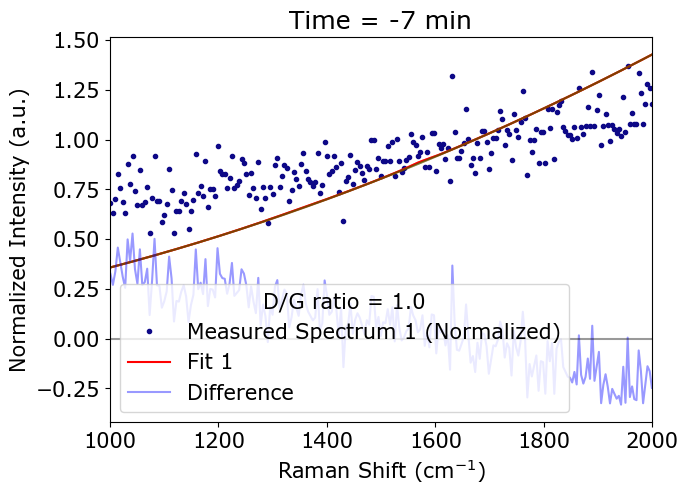

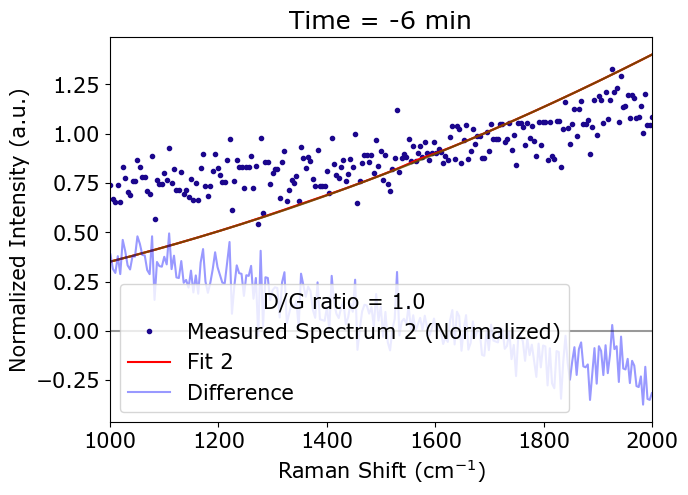

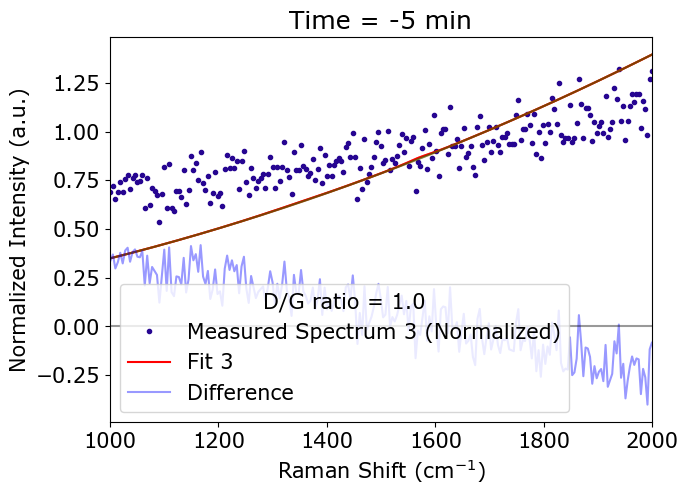

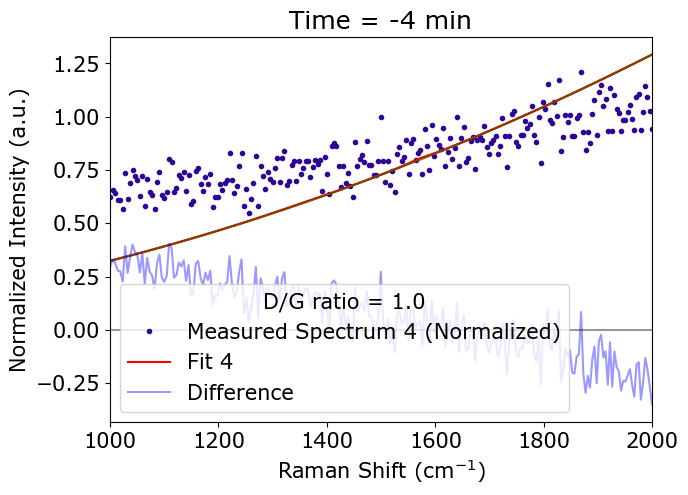

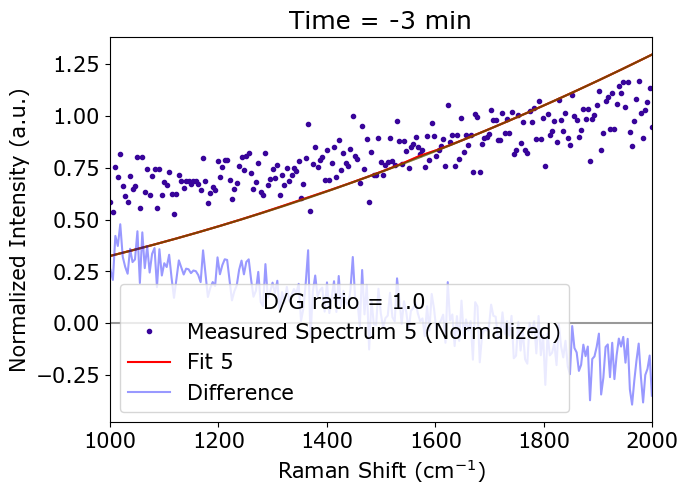

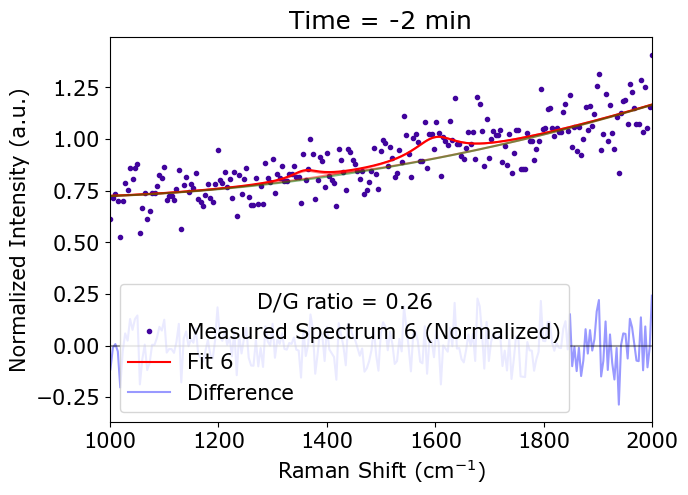

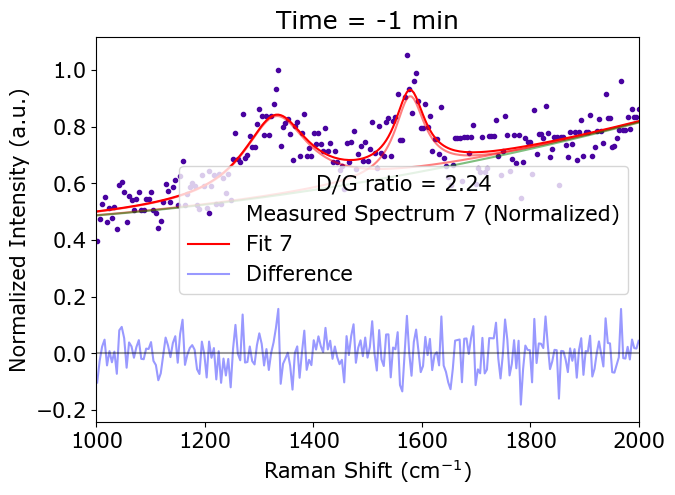

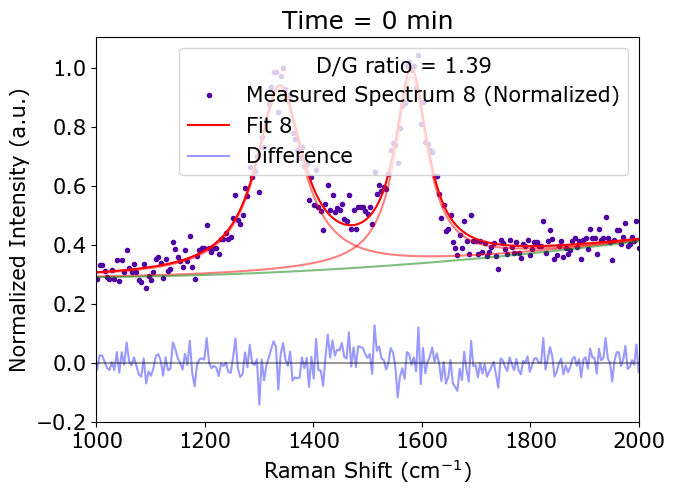

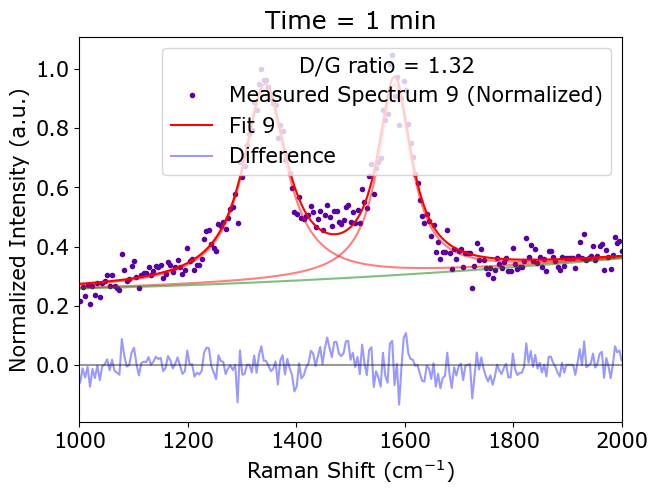

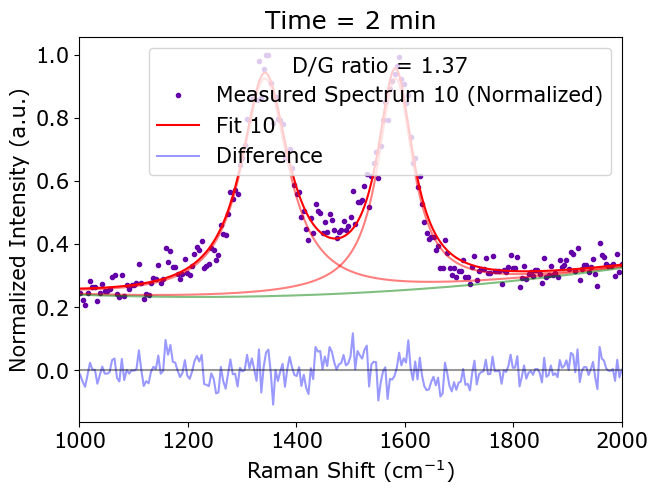

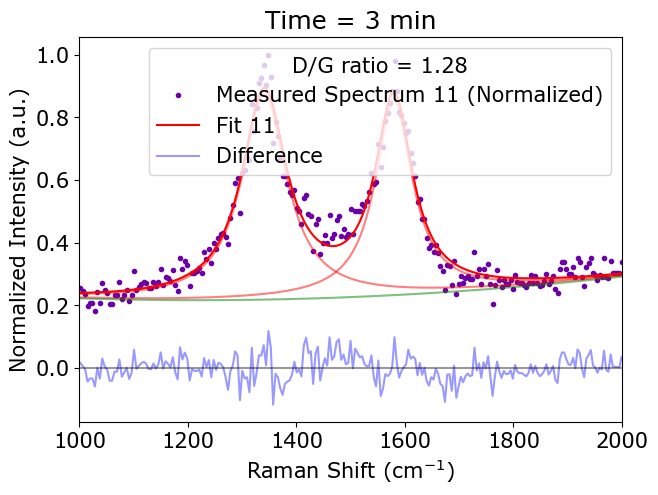

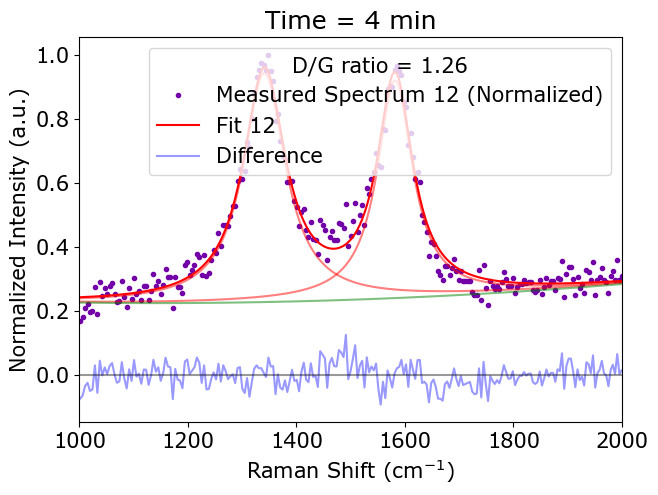

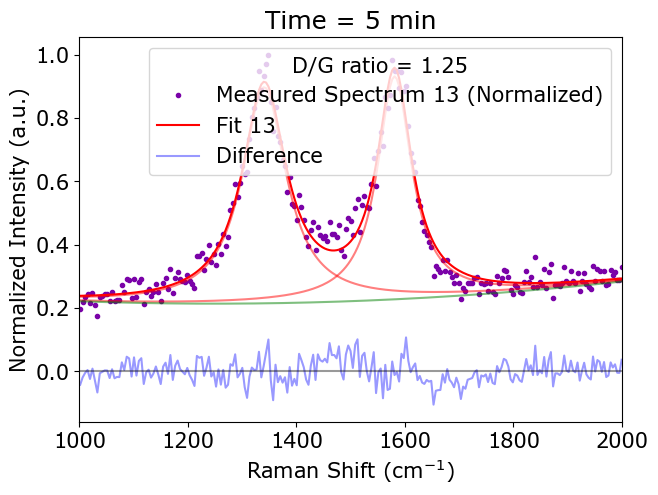

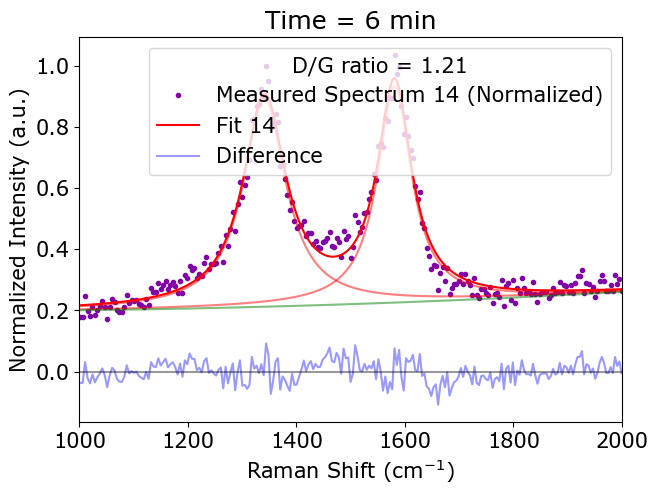

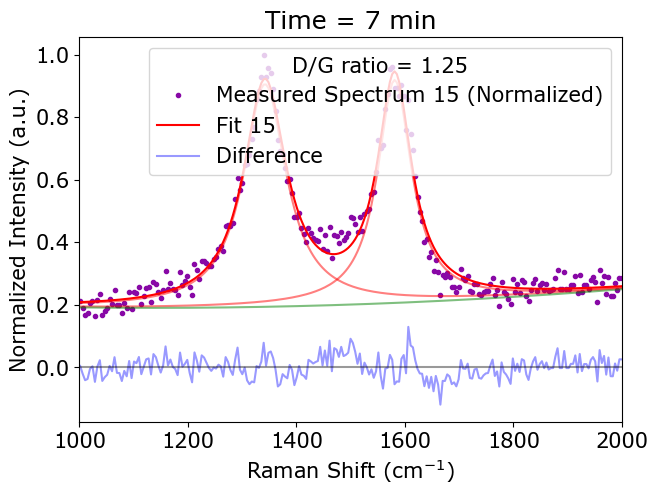

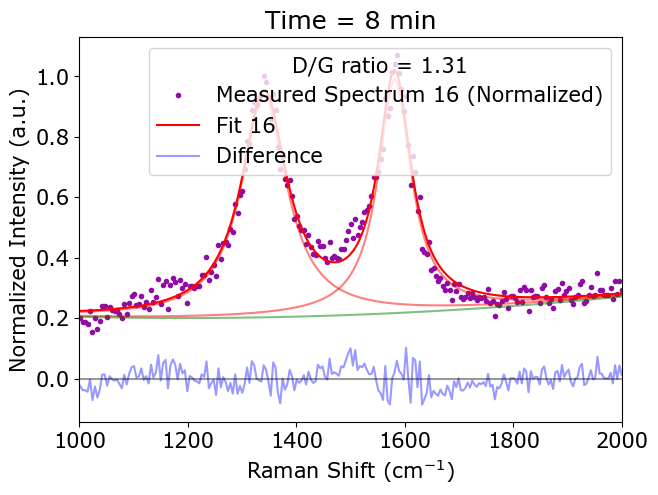

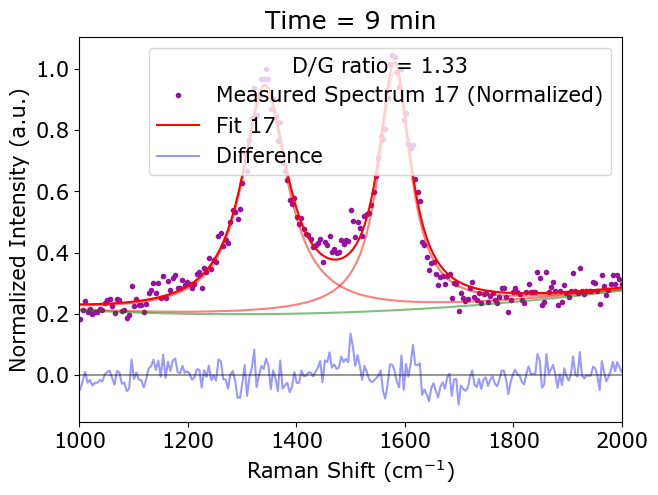

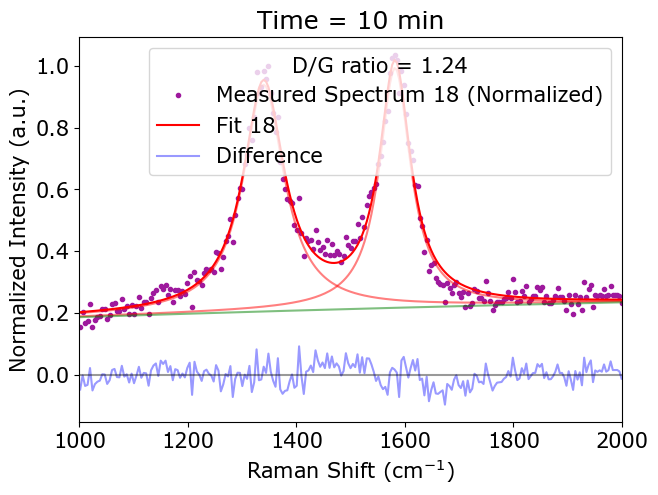

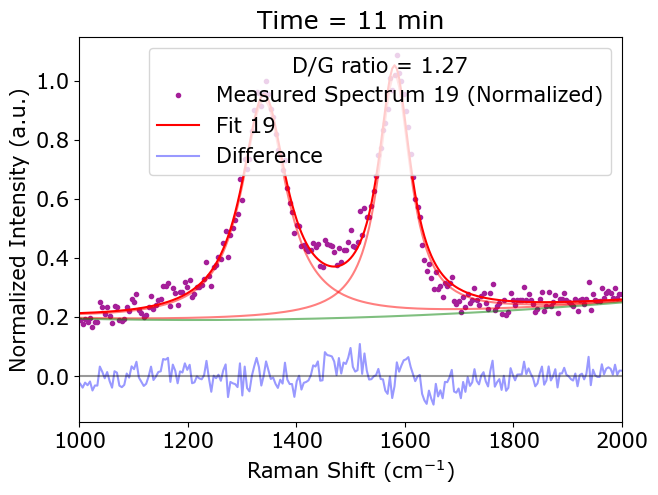

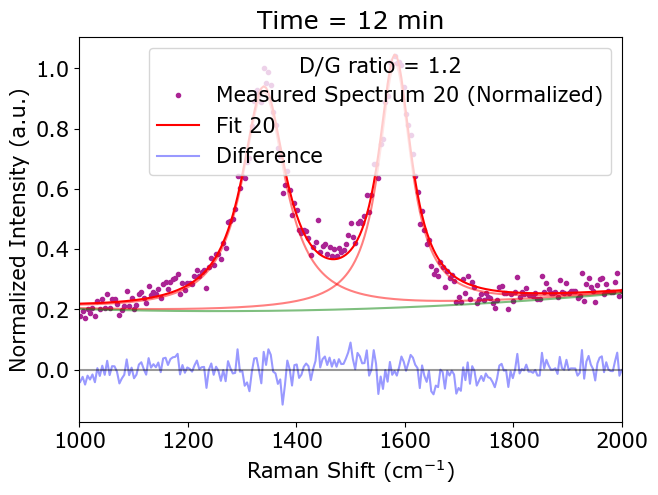

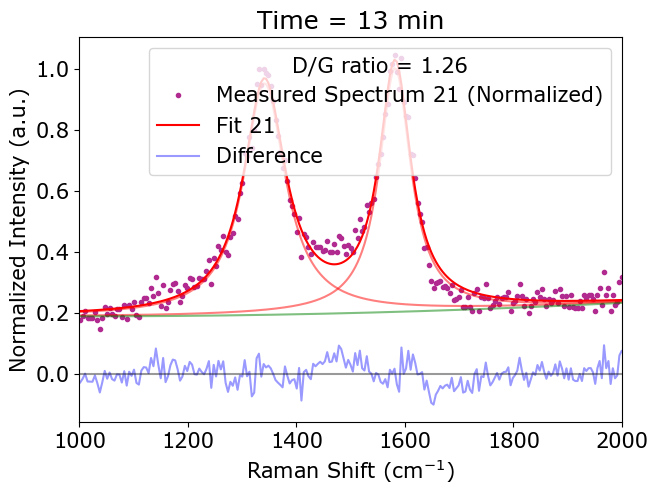

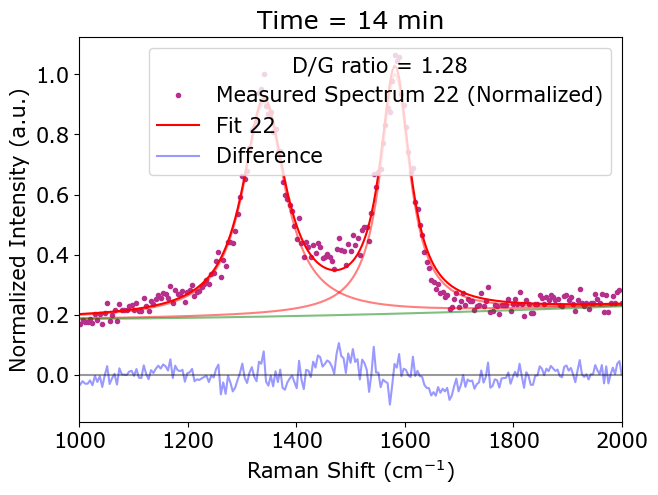

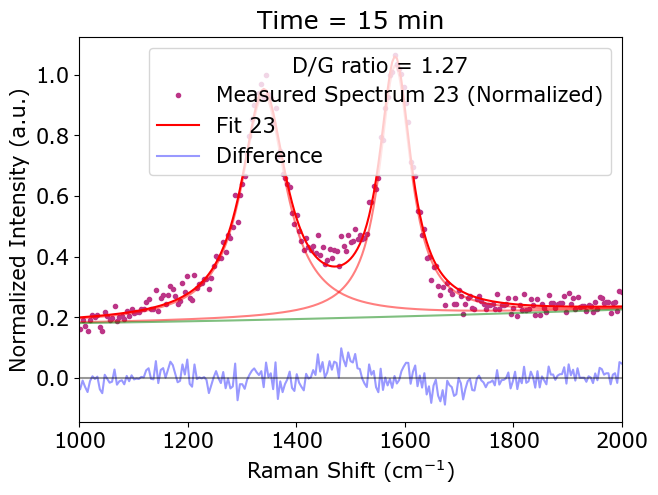

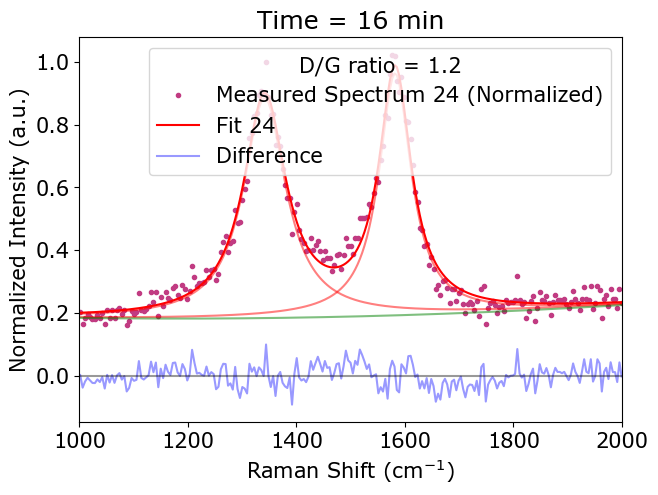

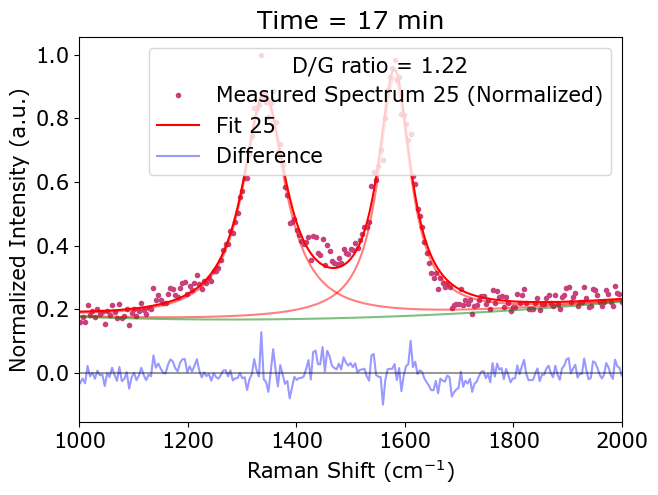

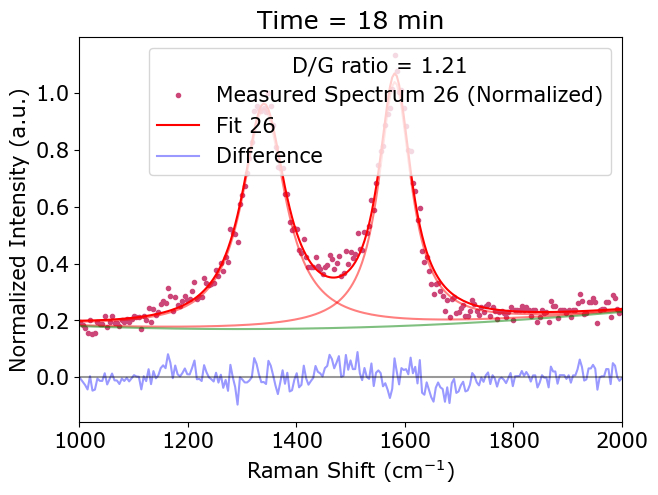

In [31]:
import matplotlib.pyplot as plt
import numpy as np

for i, (OPT, spectrum) in enumerate(zip(OPTDF, rmn)):
    fig, ax = plt.subplots(figsize=(7, 5))

    # Extract and process spectrum data
    x = spectrum['Wavenumber'].astype(float)  # Convert x-axis values to float
    y = spectrum['Intensity']
    
    # Filter data within the range
    xc = x[(x > b1) & (x < b2)]
    yc = y[(x > b1) & (x < b2)]
    
    # Normalize yc
    ycn = yc / yc[(x > 1000) & (x < 1500)].max()
    
    
    # Get the correct D/G ratio from the list
    ratioDG = ratios[i][0]  # Extract the ratio for this plot

    # Plot the normalized spectrum
    ax.plot(xc, ycn, '.', color=clr[i], label=f"Measured Spectrum {i+1} (Normalized)")

    # Fit the data using the current OPT
    fit = FUNC(xc, *OPT)
    ax.plot(xc, fit, c='red', label=f'Fit {i+1}')

    # Plot individual Lorentzians
    for j in range(0, len(OPT)-3, 3):
        L = L1(xc, OPT[j], OPT[j+1], OPT[j+2]) + OPT[-3]*xc**2 + OPT[-2]*xc + OPT[-1]
        ax.plot(xc, L, c='red', alpha=0.5)

    # Plot background
    BG = OPT[-3]*xc**2 + OPT[-2]*xc + OPT[-1]
    ax.plot(xc, BG, c='green', alpha=0.5)

    # Compute and plot the difference (residuals) using normalized data
    ax.plot(xc, ycn - fit, c='blue', alpha=0.4, label='Difference')
    ax.plot(xc, np.zeros(len(xc)), c='black', alpha=0.4)  # Zero-line for reference

    # Labels, title, and limits
    ax.set_xlabel('Raman Shift (cm$^{-1}$)')
    ax.set_ylabel('Normalized Intensity (a.u.)')
    ax.set_xlim(b1, b2)
    ax.set_title(f"Time = {int(i * measdur / 60 - starttime * measdur / 60)} min")

    # Add legend with the correct D/G ratio
    ax.legend(title=f'D/G ratio = {round(ratioDG, 2)}')

    # Show plot before moving to the next
    plt.show()


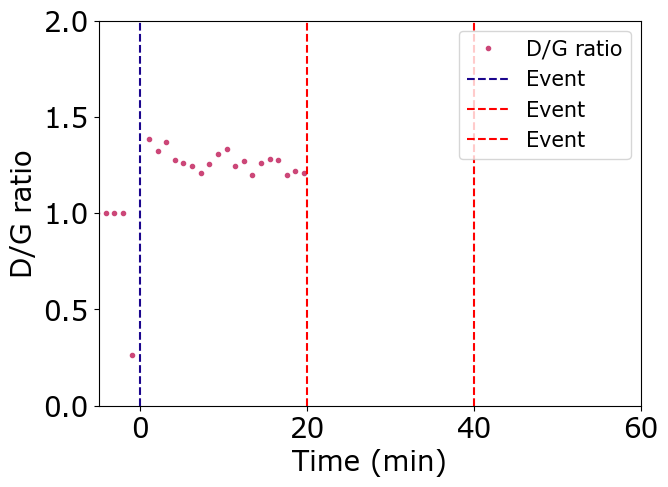

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming `ratios` is a list of [ratioDG, widthG] for each measurement
data = np.array(ratios)  # Convert to numpy array for easier handling

# Create the DataFrame directly from `ratios`
df = pd.DataFrame(data, columns=['ratioDG', 'widthG'])

# Add calculated 'TIME' and 'RTR' columns
df['TIME'] = np.arange(1 * measdur / 60 - starttime * measdur / 60, 
                       (len(df) + 1) * measdur / 60 - starttime * measdur / 60, 
                       measdur / 60)
df['RTR'] = RTR  # Assuming RTR is already defined elsewhere

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))
fsize = 20

ax.plot(df['TIME'], df['ratioDG'], '.', label='D/G ratio', color=clr[-1])
ax.set_ylim(0, 2)
ax.set_xlabel('Time (min)', fontsize=fsize)
ax.set_ylabel('D/G ratio', fontsize=fsize)

# Mark events with vertical lines
ax.axvline(x=0, color=clr[1], linestyle='--', label='Event')
ax.axvline(x=20, color='red', linestyle='--', label='Event')
ax.axvline(x=40, color='red', linestyle='--', label='Event')

# Set axis limits
ax.set_xlim(-5, 60)

# Customize tick parameters
ax.tick_params(axis='both', labelsize=fsize)

# Display legend
ax.legend()

# Save the figure if needed
plt.savefig(f"DG_ratio.svg", bbox_inches='tight')

# Show the plot
plt.show()


In [33]:
ratios

[[0.9999999999999987, 50.0],
 [0.9999999999999989, 50.0],
 [0.9999999999999989, 50.0],
 [0.9999999999999991, 50.0],
 [0.9999999999999991, 50.0],
 [0.26416252489819736, 99.99999999999989],
 [2.239611294595219, 66.84256793439694],
 [1.387206262845975, 72.91433359485059],
 [1.3234088908802122, 75.12475629828235],
 [1.369199458030281, 79.43573451663941],
 [1.278109243243762, 83.28503680421235],
 [1.262493516907536, 79.1289003419023],
 [1.247355044986998, 76.70523474923934],
 [1.2069522742194005, 76.08167270312018],
 [1.2544001619487695, 76.3210800399607],
 [1.3051216658736937, 74.17337090967227],
 [1.332486232248728, 71.83476220555555],
 [1.2435515794559806, 69.89172657322082],
 [1.2698977575133978, 71.88958654125597],
 [1.1980614504923346, 72.8971002483885],
 [1.2595702922368521, 70.62009058651918],
 [1.280848863262986, 66.45561777382821],
 [1.274262242121564, 70.54802900667354],
 [1.1978020313554547, 72.30477261449595],
 [1.2218850458095056, 72.99919355989087],
 [1.2088595597230052, 72.5

In [34]:
import os
import pandas as pd
import numpy as np

script_dir = os.getcwd()
folder_name = os.path.basename(script_dir)

# Specify the folder path you want to save the data to
folder_path = r'C:\Users\6104029\OneDrive - Universiteit Utrecht\PhD\Labwork\Data\Raman\DGratios'

# Ensure the folder exists, create if not
os.makedirs(folder_path, exist_ok=True)

# Extract the D/G ratios for each dataset
ratios = [[ratioDG, widthG] for ratioDG, widthG in ratios]

# Create a DataFrame to save the D/G ratios and associated time
df = pd.DataFrame(ratios, columns=['ratioDG', 'widthG'])

# Calculate TIME based on measurements and start time
df['TIME'] = np.arange(1 * measdur / 60 - starttime * measdur / 60, 
                       (len(df) + 1) * measdur / 60 - starttime * measdur / 60, 
                       measdur / 60)

# Optionally, add RTR if necessary
df['RTR'] = RTR  # Assuming RTR is defined elsewhere in your script

# Create a filename using the folder name (folder name can still be used as part of the filename)
file_name = f'{folder_name}_dg_ratios_data.csv'

# Save the DataFrame to CSV in the specified folder
file_path = os.path.join(folder_path, file_name)
df.to_csv(file_path, index=False)

print(f"D/G ratios data saved to {file_path}")


D/G ratios data saved to C:\Users\6104029\OneDrive - Universiteit Utrecht\PhD\Labwork\Data\Raman\DGratios\20250513_HS006_400C_20min_dg_ratios_data.csv


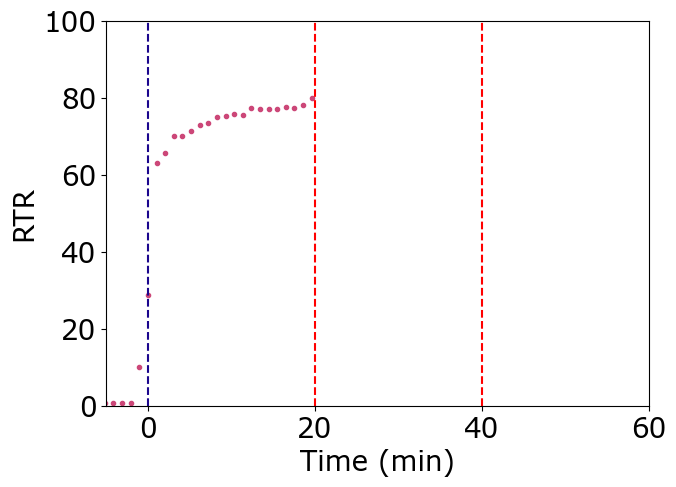

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
fsize = 20
ax.plot(df['TIME'], df['RTR'], '.', label='RTR', color=clr[-1])
ax.set_ylim(0, 100)
ax.set_xlabel('Time (min)', fontsize=fsize)
ax.set_ylabel('RTR', fontsize=fsize)
ax.axvline(x=0, color= clr[1], linestyle='--', label='Event')
ax.set_xlim(-5, 60)
plt.axvline(x=20, color= 'red', linestyle='--', label='Event')
ax.axvline(x=40, color= 'red', linestyle='--', label='Event')

ax.tick_params(axis='both', labelsize=fsize)


plt.savefig(f"RTR.svg", bbox_inches='tight')

In [36]:
ratios

[[0.9999999999999987, 50.0],
 [0.9999999999999989, 50.0],
 [0.9999999999999989, 50.0],
 [0.9999999999999991, 50.0],
 [0.9999999999999991, 50.0],
 [0.26416252489819736, 99.99999999999989],
 [2.239611294595219, 66.84256793439694],
 [1.387206262845975, 72.91433359485059],
 [1.3234088908802122, 75.12475629828235],
 [1.369199458030281, 79.43573451663941],
 [1.278109243243762, 83.28503680421235],
 [1.262493516907536, 79.1289003419023],
 [1.247355044986998, 76.70523474923934],
 [1.2069522742194005, 76.08167270312018],
 [1.2544001619487695, 76.3210800399607],
 [1.3051216658736937, 74.17337090967227],
 [1.332486232248728, 71.83476220555555],
 [1.2435515794559806, 69.89172657322082],
 [1.2698977575133978, 71.88958654125597],
 [1.1980614504923346, 72.8971002483885],
 [1.2595702922368521, 70.62009058651918],
 [1.280848863262986, 66.45561777382821],
 [1.274262242121564, 70.54802900667354],
 [1.1978020313554547, 72.30477261449595],
 [1.2218850458095056, 72.99919355989087],
 [1.2088595597230052, 72.5

# Temperature plotting 

In [37]:
filestemp = glob.glob("*m_.txt")
for i, file in enumerate(filestemp):
    columns = ['Date', 'Time', 'Oven sp', 'Oven temp', 'Oven ramp', 'H2 SP', 'H2 flow', 'CO sp', 'CO flow', 'CO2 sp', 'CO2 flow', 'Ar sp', 'Ar flow', 'BPC SP', 'BPC Pres', 'Press sens']
    temp = pd.read_csv(filestemp[i], sep='\t', header=1, names=columns, skiprows=1, index_col=False)
temp
temp['Time'] = temp['Time'].str.replace(r' AM| PM', '', regex=True)  # Remove AM/PM
temp['Time'] = pd.to_datetime(temp['Time'], format='%I:%M:%S')  # Convert to 24-hour format
temp['Time'] = temp['Time'].dt.strftime('%H:%M:%S')
temp['Date'] = pd.to_datetime(temp['Date'], format = '%m/%d/%Y')
temp['Date'] = temp['Date'].dt.strftime('%d/%m/%Y')
temp.drop(columns=columns[5:], inplace=True)  # Drop the 'Date' column if not needed
temp = temp.iloc[::5, :]
print(temp)


NameError: name 'temp' is not defined

# MS plotting

In [ ]:
filesms = glob.glob("*.asc")
for i, file in enumerate(filesms):
    columns = ['Cycle', 'Date', 'Time', 'RelTime[s]', '2', '12', '14', '15', '16', '18', '28', '40', '44', 'PKR']
    MS = pd.read_csv(filesms[i], sep='\t', header=None, names=columns, skiprows=22, index_col=False)

MS['Time'] = MS['Time'].str.replace(r' AM| PM', '', regex=True)  # Remove AM/PM
MS['Time'] = pd.to_datetime(MS['Time'], format='%H:%M:%S:%f')  # Convert to 24-hour format
MS['Time'] = MS['Time'].dt.strftime('%H:%M:%S')
# MS['Date'] = pd.to_datetime(MS['Date'], format = '%m/%d/%Y')
# MS['Date'] = MS['Date'].dt.strftime('%d/%m/%Y')
print(MS)

     Cycle        Date      Time  RelTime[s]             2            12  \
0        3  10/04/2025  11:32:49      30.709  1.989930e-12  3.563620e-13   
1        4  10/04/2025  11:33:09      50.748  1.138440e-09  6.507350e-13   
2        5  10/04/2025  11:33:29      70.946  1.362000e-09  3.903450e-13   
3        6  10/04/2025  11:33:49      90.955  1.308470e-09  3.303430e-13   
4        7  10/04/2025  11:34:10     111.000  1.315440e-09  2.881960e-13   
..     ...         ...       ...         ...           ...           ...   
824    827  10/04/2025  16:08:19   16560.900  3.178980e-11  1.349610e-11   
825    828  10/04/2025  16:08:40   16581.000  3.210580e-11  1.390520e-11   
826    829  10/04/2025  16:09:00   16601.100  3.128750e-11  1.250170e-11   
827    830  10/04/2025  16:09:20   16621.200  3.067350e-11  1.224290e-11   
828    831  10/04/2025  16:09:40   16641.200  3.209700e-11  1.444590e-11   

               14            15            16            18            28  \
0    3.975

In [ ]:
import pandas as pd

def align_data(temp, MS, ratios):
    # Convert ratios to DataFrame with columns 'D/G' and 'Value'
    ratios_df = pd.DataFrame(ratios, columns=['D/G', 'Value'])

    # Create Datetime for ratios starting at 12:48 and incrementing every 62 seconds
    ratios_df["Datetime"] = [start_time + pd.Timedelta(seconds=62 * i) for i in range(len(ratios_df))]

    # Convert datetime columns
    MS["Datetime"] = pd.to_datetime(MS["Date"] + " " + MS["Time"], format='%d/%m/%Y %H:%M:%S')
    temp["Datetime"] = pd.to_datetime(temp["Date"] + " " + temp["Time"], format='%d/%m/%Y %H:%M:%S')

    # Adjust timestamps
    MS["Adjusted Datetime"] = MS["Datetime"] - pd.Timedelta(minutes=2)
    temp["Adjusted Datetime"] = temp["Datetime"] + pd.Timedelta(minutes=4)

    # Align MS using merge_asof
    MS_aligned = pd.merge_asof(
        ratios_df.sort_values("Datetime"),
        MS.sort_values("Adjusted Datetime"),
        left_on="Datetime", right_on="Adjusted Datetime",
        direction='nearest'
    )

    # Align MS using merge_asof
    temp_aligned = pd.merge_asof(
        ratios_df.sort_values("Datetime"),
        temp.sort_values("Adjusted Datetime"),
        left_on="Datetime", right_on="Adjusted Datetime",
        direction='nearest'
    )
    return MS_aligned, temp_aligned

# Example usage:
MS_aligned, temp_aligned = align_data(temp, MS, ratios)
MS_aligned['RelTime[min]'] = MS_aligned['RelTime[s]'] / 60 - (MS_aligned['RelTime[s]'] / 60)[starttime]
# Optional printout
# print("MS Aligned Data:")
print(MS_aligned.head())
# print("Temperature Aligned Data:")
print(temp_aligned.head())


   D/G  Value          Datetime_x  Cycle        Date      Time  RelTime[s]  \
0  1.0   50.0 2025-04-10 15:06:00    647  10/04/2025  15:08:04     12945.4   
1  1.0   50.0 2025-04-10 15:07:02    650  10/04/2025  15:09:04     13005.6   
2  1.0   50.0 2025-04-10 15:08:04    653  10/04/2025  15:10:04     13065.7   
3  1.0   50.0 2025-04-10 15:09:06    656  10/04/2025  15:11:05     13126.2   
4  1.0   50.0 2025-04-10 15:10:08    659  10/04/2025  15:12:05     13186.5   

              2            12            14            15            16  \
0  6.750030e-12  5.900500e-12  6.133290e-12  9.027060e-12  5.115200e-12   
1  4.683270e-12  4.912580e-12  4.510350e-12  4.642730e-12  4.548500e-12   
2  5.310280e-12  4.446840e-12  4.162740e-12  4.401700e-12  4.354650e-12   
3  6.286680e-11  1.143600e-11  6.221400e-11  4.913510e-10  6.059030e-10   
4  7.093900e-11  1.211120e-11  6.369150e-11  4.982430e-10  6.127300e-10   

             18            28            40            44       PKR  \
0  7.1968

In [ ]:
# Create Datetime for ratios starting at 12:48 and incrementing every 62 seconds
ratios_df = pd.DataFrame(ratios, columns=['D/G', 'Value'])
ratios_df["Datetime"] = [start_time + pd.Timedelta(seconds=62 * i) for i in range(len(ratios_df))]
ratios_df

,D/G,Value,Datetime
0,1.000000,50.000000,2025-04-10 15:06:00
1,1.000000,50.000000,2025-04-10 15:07:02
2,1.000000,50.000000,2025-04-10 15:08:04
3,1.000000,50.000000,2025-04-10 15:09:06
4,1.000000,50.000000,2025-04-10 15:10:08
...,...,...,...
57,1.939976,66.150619,2025-04-10 16:04:54
58,1.629403,69.231805,2025-04-10 16:05:56
59,1.782244,66.739434,2025-04-10 16:06:58
60,1.592361,82.074218,2025-04-10 16:08:00


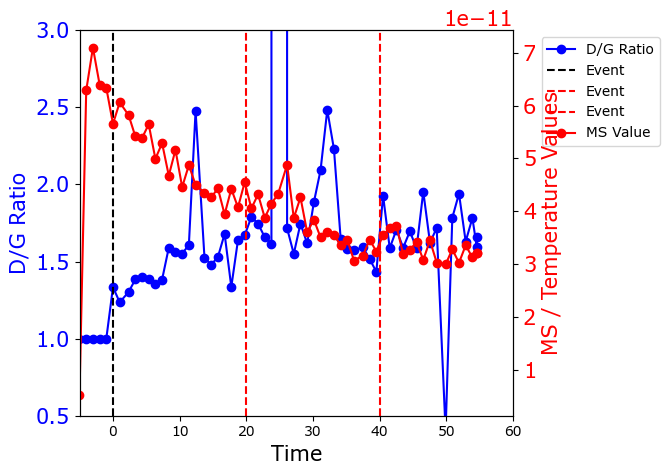

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(7, 5))
    
    
# Convert ratios to DataFrame with columns 'D/G' and 'Value'
ratios = pd.DataFrame(ratios, columns=['D/G', 'Value'])

# Plot the D/G ratio data (assuming the first column is the D/G ratio)
ax1.plot(MS_aligned["RelTime[min]"], MS_aligned["D/G"], color='b', label="D/G Ratio", linestyle='-', marker='o')
ax1.set_xlabel('Time')
ax1.tick_params(axis='x', labelsize=10)
ax1.set_ylabel('D/G Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second axis to plot MS and temperature data
ax2 = ax1.twinx()
    
# Plot the MS data (assuming MS columns of interest are labeled correctly)
ax2.plot(MS_aligned["RelTime[min]"], MS_aligned["2"], color='r', label="MS Value", linestyle='-', marker='o')

# Set the second axis labels
ax2.set_ylabel('MS / Temperature Values', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.axvline(x=0, color='black', linestyle='--', label='Event')
ax1.axvline(x=20, color='red', linestyle='--', label='Event')
ax1.axvline(x=40, color='red', linestyle='--', label='Event')

# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
# ax3.set_ylabel('Temperature Values', color='g')
# ax3.tick_params(axis='y', labelcolor='g')
# # Plot the temp data (assuming temp columns of interest are labeled correctly)
# ax3.plot(temp_aligned["Datetime"], temp_aligned["Oven temp"], color='g', label="Temperature Value", linestyle='-', marker='^')

# Title and legends
# ax1.set_title('Aligned D/G Ratio, MS, and Temperature Data')

# Get the legend handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine them
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Plot the combined legend on one of the axes (usually ax1)
ax1.legend(all_handles, all_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.set_xlim(-5, 60)
ax1.set_ylim(0.5, 3)
plt.savefig(f"MS DG combined.svg", bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()